In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

In [2]:
all_zips = pd.read_csv("../write_data/zillow_housing_zipcodes.csv")
all_zips['Date_index'] = pd.to_datetime(all_zips['Date_index'])
all_zips = all_zips.set_index('Date_index')

In [3]:
top_five = ['28208', '78758', '78612', '37033', '27504']

In [4]:
data_of_interest = all_zips.filter(items=top_five)

In [5]:
data_of_interest

,28208,78758,78612,37033,27504
Date_index,,,,,
1996-04-01,59000.0,129000.0,76500.0,41100.0,82700.0
1996-05-01,59300.0,128300.0,76300.0,41400.0,83200.0
1996-06-01,59500.0,127500.0,76100.0,41600.0,83700.0
1996-07-01,59800.0,126900.0,76000.0,41800.0,84300.0
1996-08-01,60000.0,126300.0,75900.0,42000.0,84800.0
...,...,...,...,...,...
2017-12-01,102800.0,250500.0,200700.0,81600.0,146000.0
2018-01-01,105100.0,255100.0,200600.0,82400.0,146500.0
2018-02-01,107300.0,260100.0,203000.0,83400.0,147200.0


In [6]:
model_28208 = data_of_interest['28208']

In [7]:
df_for_prophet = model_28208.reset_index().rename(columns={'Date_index': 'ds', '28208': 'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
//anaconda3/envs/mod04-project/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasona

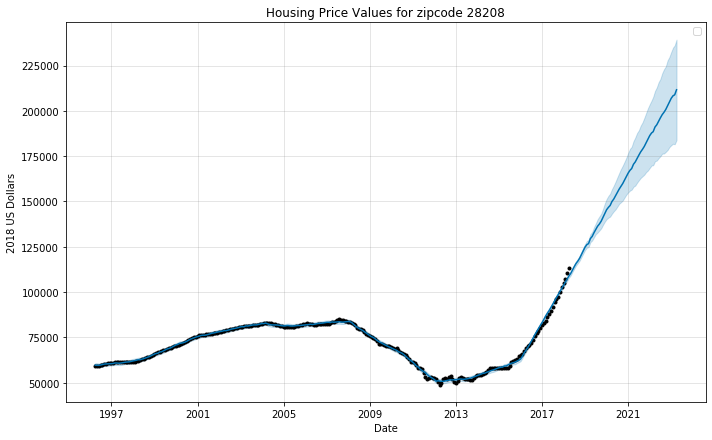

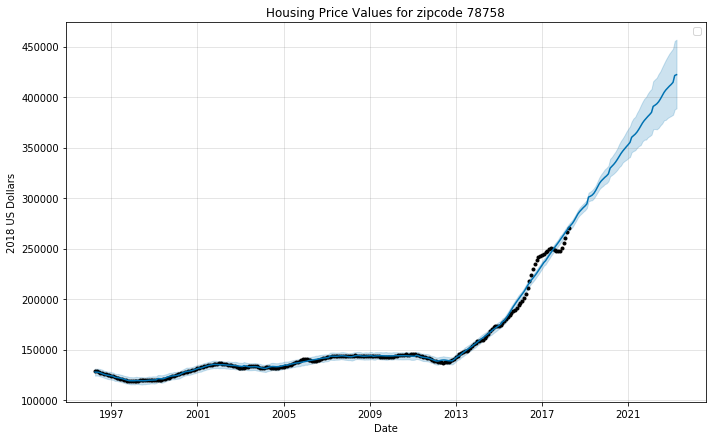

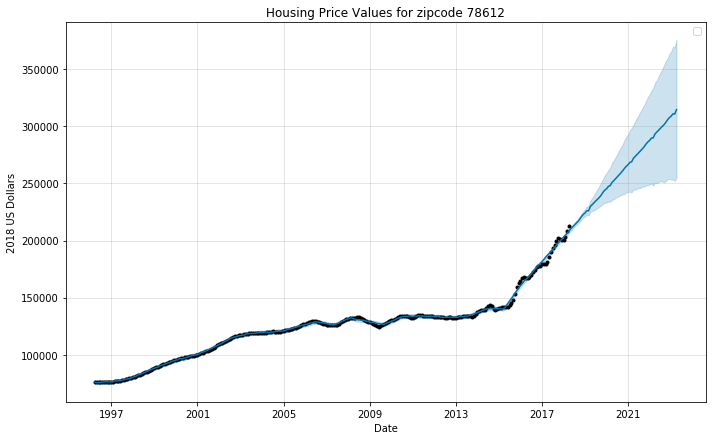

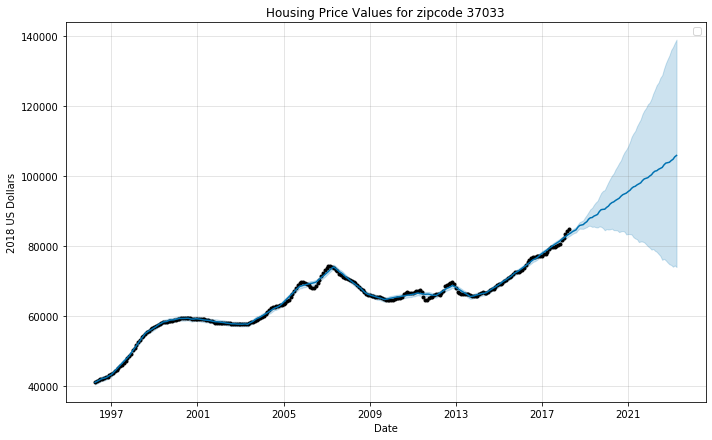

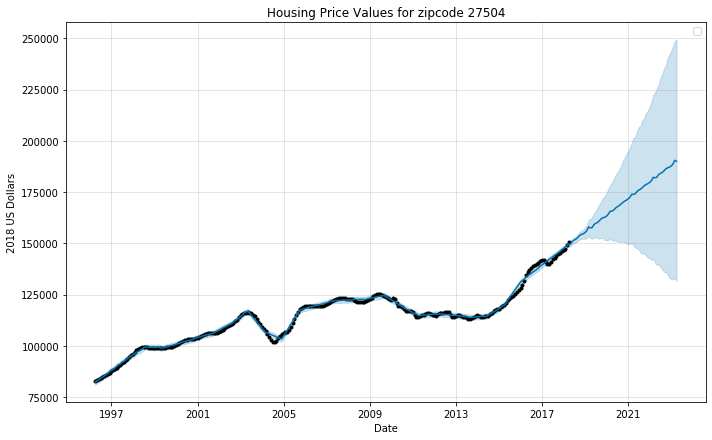

In [8]:
ds, yhat_lower, yhat, ys, yhat_upper, zipcode = [], [], [], [], [], []

for zippy in data_of_interest:
    df_for_prophet = data_of_interest[zippy].reset_index().rename(columns={'Date_index': 'ds', f'{zippy}': 'y'})
    m = Prophet(interval_width=0.8, 
                        n_changepoints=25, 
                        changepoint_range=0.9, 
                        changepoint_prior_scale=0.18)

    m.fit(df_for_prophet)
    future = m.make_future_dataframe(periods=60, freq='M')
    forecast = m.predict(future)
    ds.extend(forecast['ds'].values)
    yhat_lower.extend(forecast['yhat_lower'].values)
    yhat.extend(forecast['yhat'].values)
    yhat_upper.extend(forecast['yhat_upper'].values)
    zipcode.extend(np.repeat(zippy, forecast.shape[0]))

    zip_data = pd.DataFrame({'time': ds, 
                             'yhat_lower': yhat_lower, 
                             'yhat': yhat, 
                             'yhat_upper': yhat_upper, 
                             'Zip_code': zipcode})
    
    zip_data.to_csv(f"../write_data/{zippy}_forecast_values.csv")
    
    data_of_interest[zippy].to_csv(f"../write_data/{zippy}_original_values.csv")

    fig = m.plot(forecast, 
                 xlabel='Date', 
                 ylabel='2018 US Dollars', 
                )
    
    plt.legend(loc='best')
    plt.title(f'Housing Price Values for zipcode {zippy}')
    plt.savefig(f"../write_data/Predicted_plots_for_{zippy}")

In [9]:
zip_data[zip_data['time'] == '2019-08-31']

,time,yhat_lower,yhat,yhat_upper,Zip_code
281,2019-08-31,133998.416306,137579.559960,141722.263969,28208
606,2019-08-31,308738.559951,314449.279022,320464.655374,78758
931,2019-08-31,229706.455613,237758.580347,247720.832534,78612
1256,2019-08-31,85584.324192,89850.940602,94099.069424,37033
1581,2019-08-31,152277.758288,160990.154320,169140.625349,27504


Sales values from Zillow for August 2019:
Charlotte, NC 28208, : $135,100, use lower values
Austin, TX 78758: $307,000, use lower values
Cedar Creek, TX 78612 (Austin area): $254,100, use upper values
Centerville, TN 37033 (Nashville area): $103,300, use upper values
Benson, NC 27504 (Raleigh area): $167,800, use upper values

In [75]:
top_five_town = ['Charlotte, NC 28208',
                 'Austin, TX 78758',
                 'Cedar Creek, TX 78612 (Austin)',
                 'Centerville, TN 37033 (Nashville)', 
                 'Benson, NC 27504 (Raleigh)']

In [16]:
act_resid = [133998 - 135100, 308738 - 307000, 247720 - 254100, 94099 - 103300, 169140 - 167800]

In [29]:
scaled_resid = [(133998 - 135100)/135100, 
             (308738 - 307000)/307000, 
             (247720 - 254100)/254100, 
             (94099 - 103300)/103300, 
             (169140 - 167800)/167800]

In [30]:
pct_resid = 100 * np.array(scaled_resid)

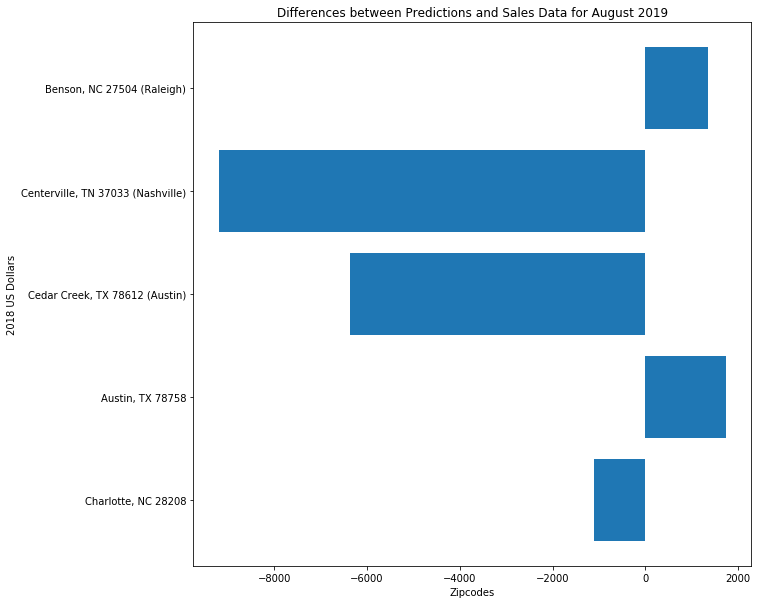

In [89]:
plt.figure(figsize=(10,10))
plt.barh(y=top_five_town, width=act_resid)
plt.xlabel("Zipcodes")
plt.ylabel("2018 US Dollars")
plt.title("Differences between Predictions and Sales Data for August 2019")
plt.savefig(f"../write_data/diff_btwn_pred_act_dollars.png", bbox_inches='tight')
plt.show()

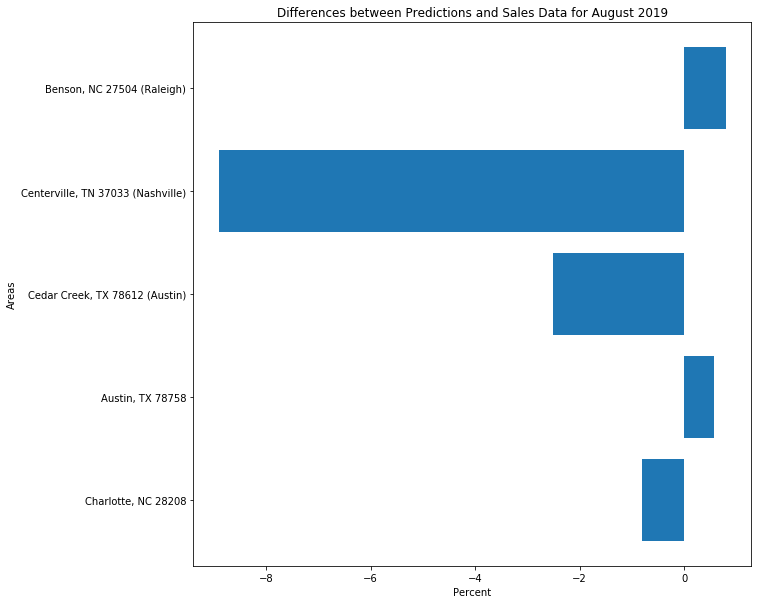

In [88]:
plt.figure(figsize=(10,10))
plt.barh(y=top_five_town, width=pct_resid)
plt.ylabel("Areas")
plt.xlabel("Percent")
plt.title("Differences between Predictions and Sales Data for August 2019")
plt.savefig(f"../write_data/diff_btwn_pred_act_pct.png", bbox_inches='tight')
plt.show()

In [68]:
zip_data[zip_data['time'] == '2021-12-31']

,time,yhat_lower,yhat,yhat_upper,Zip_code
309,2021-12-31,168489.351426,186296.490739,203549.639530,28208
634,2021-12-31,361346.249456,382722.826188,406076.473784,78758
959,2021-12-31,249046.299875,287774.355244,327845.833872,78612
1284,2021-12-31,79507.417137,99996.644350,121008.416552,37033
1609,2021-12-31,142949.273469,179705.734723,216678.576716,27504


In [69]:
pred_return = [168489 - 135100, 361346 - 307000, 327845 - 254100, 121008 - 103300, 216678 - 167800]

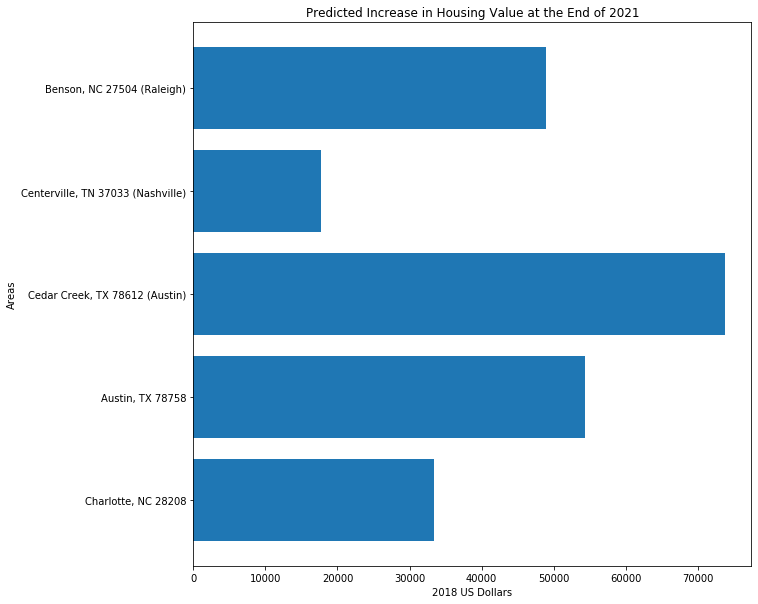

In [87]:
plt.figure(figsize=(10,10))
plt.barh(y=top_five_town, width=pred_return)
plt.ylabel("Areas")
plt.xlabel("2018 US Dollars")
plt.title("Predicted Increase in Housing Value at the End of 2021")
plt.savefig(f"../write_data/dollar_return_2021.png", bbox_inches='tight')
plt.show()

In [72]:
scaled_returns = [(168489 - 135100)/135100, 
                  (361346 - 307000)/307000, 
                  (327845 - 254100)/254100, 
                  (121008 - 103300)/103300, 
                  (216678 - 167800)/167800]

In [73]:
pct_return = 100* np.array(scaled_returns)

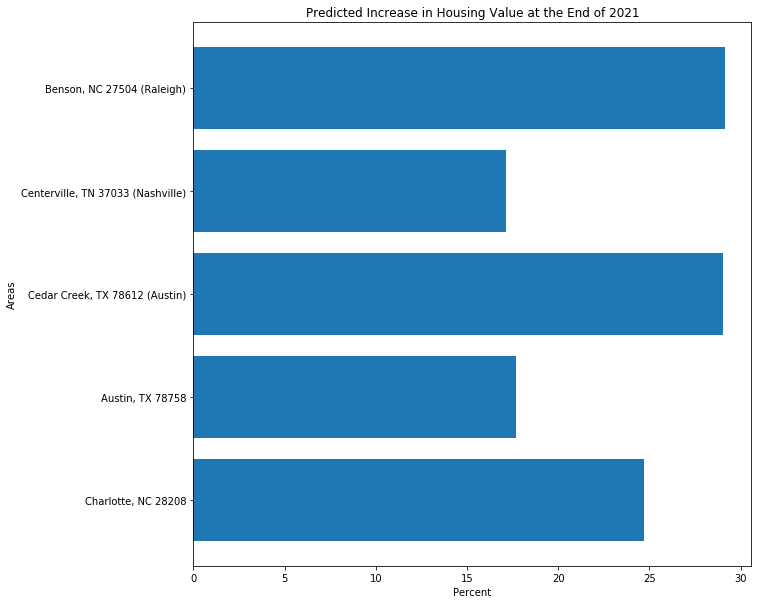

In [86]:
plt.figure(figsize=(10,10))
plt.barh(y=top_five_town, width=pct_return)
plt.ylabel("Areas")
plt.xlabel("Percent")
plt.title("Predicted Increase in Housing Value at the End of 2021")
plt.savefig(f"../write_data/percent_return_2021.png", bbox_inches='tight')
plt.show()